# **Gaussian Processes**

    Notebook version: 1.0 (Oct 06, 2015)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - Figures changed to png (tiff not readable in Firefox)

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab

# 4. Gaussian Processes

## 4.1 The multivariate Gaussian distribution

Let us assume that ${\bf x}$ and ${\bf y}$ are two jointly Gaussian random vectors, whose joint pdf can be expressed as

\begin{equation}
\left[ \begin{array}{c} {\bf x} \\ {\bf y} \end{array} \right] \sim {\cal{N}} \left( \left[ \begin{array}{c} {\bf m}_{\bf x} \\ {\bf m}_{\bf y} \end{array} \right] , \left[ \begin{array}{cc} {\pmb \Sigma}_{{\bf x}{\bf x}} & {\pmb \Sigma}_{{\bf x}{\bf y}} \\ {\pmb \Sigma}_{{\bf x}{\bf y}}^T & {\pmb \Sigma}_{{\bf y}{\bf y}}\end{array}\right] \right) = {\cal{N}} \left( \left[ \begin{array}{c} {\bf m}_{\bf x} \\ {\bf m}_{\bf y} \end{array} \right] , \left[ \begin{array}{cc} \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf x}} & \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf y}} \\ \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf y}}^T & \widetilde{{\pmb \Sigma}}_{{\bf y}{\bf y}}\end{array}\right]^{-1} \right)
\end{equation}

where

   - ${\bf m}_{\bf x}$: Mean of random vector ${\bf x}$
   - ${\bf m}_{\bf y}$: Mean of random vector ${\bf y}$
   - ${\pmb \Sigma}_{{\bf x}{\bf x}}$: Covariance matrix of random vector ${\bf x}$
   - ${\pmb \Sigma}_{{\bf x}{\bf y}}$: Cross-covariance matrix of ${\bf x}$ and ${\bf y}$

Note that all blocks of the covariance matrix and its inverse are of appropriate sizes, as indicated by the subindexes. We are using tildes for the blocks of the inverse of the covariance matrix. Please, be aware that $\widetilde{\pmb\Sigma}_{{\bf x}{\bf x}} \neq {\pmb\Sigma}_{{\bf x}{\bf x}}^{-1}$.

<img src="figs/Gaussian2D.png", style="width: 80%">

Since random vectors are jointly Gaussian, this means that marginal and conditional distributions are also Gaussian, with distributions that can be expresses as

$${\bf x} \sim {\cal{N}} ({\bf m}_{\bf x}, {\pmb \Sigma}_{{\bf x}{\bf x}}) \qquad \qquad {\bf y} \sim {\cal{N}} ({\bf m}_{\bf y}, {\pmb \Sigma}_{{\bf y}{\bf y}})$$


$${\bf x}|{\bf y} \sim {\cal{N}} ( {\bf m}_{\bf x} - \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf x}}^{-1} \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf y}} ({\bf y} - {\bf m}_{\bf y}), \widetilde{{\pmb \Sigma}}_{{\bf x}{\bf x}}^{-1})$$

$${\bf x}|{\bf y} \sim {\cal{N}} ( {\bf m}_{\bf x} + {{\pmb \Sigma}}_{{\bf x}{\bf y}} {{\pmb \Sigma}}_{{\bf y}{\bf y}}^{-1} ({\bf y} - {\bf m}_{\bf y}), {{\pmb \Sigma}}_{{\bf x}{\bf x}} - {\pmb \Sigma}_{{\bf x}{\bf y}} {{\pmb \Sigma}}_{{\bf y}{\bf y}}^{-1} {\pmb \Sigma}_{{\bf x}{\bf y}}^\top)$$

The demonstration of these expressions is left as an exercise

### Generation of Samples from a Multivariate Gaussian Distribution

Although there are python routines that can help to generate points from a multivariate Gaussian distribution, a standard procedure is based upon the generation of samples from the normal distribution with zero mean and unitary standard deviation, which are then transformed in an appropritate manner.

The Cholesky decomposition of a symmetric positive-definite matrix ${\bf A}$ is (the definition can be slightly modified for complex matrices, but here we restrict our selves to matrices with real values):

$${\bf A} = {\bf L} {\bf L}^\top$$

where ${\bf L}$ is a lower triangular matrix with positive diagonal entries. It can be shown that such decomposition exists and is unique, and can be computed in a very stable an efficient way.

Now, imaging the problem of drawing points from the Gaussian distribution

$$p({\bf x}) = {\cal N}\left({\bf m},{\pmb \Sigma} \right)$$

This distribution can be sampled by drawing points ${\bf x}'$ from ${\cal N}\left({\bf 0},{\bf I} \right)$, and then applying the transformation

$${\bf x} = {\bf L} {\bf x}'~+~{\bf m}$$

where ${\bf L}$ is obtained from the Cholesky decomposition of $\pmb \Sigma$.

The demonstration of the validity of the process goes along these lines:

   - Since ${\bf x}$ is a linear transformation of a Gaussian variable, it should also be normally distributed
   
   - ${\mathbb E}\{{\bf x}\} = {\bf L} \mathbb{E}\{{\bf x}'\} + {\bf m} = {\bf m}$
   
   - $\text{Cov}\{{\bf x}\} = \text{Cov}\{{\bf L} {\bf x}'\} = {\mathbb E} \{{\bf L} {\bf x}' {{\bf x}'}^\top {\bf L}^\top\} = {\bf L} {\bf L}^\top = {\pmb \Sigma}$

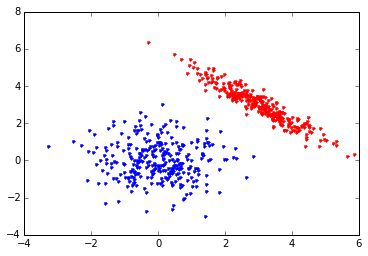

In [2]:
#This code illustrates the generation of multivariate Gaussian points with arbitrary distribution
m = np.array([3,3])
V = np.array([[1,-0.95],[-0.95,1]])

L = np.linalg.cholesky(V)

#Generation of points from the normal distribution with zero mean and unit variance
n_points = 300
dim = 2
x_prime = np.random.randn(dim,n_points)

#Linear transformation
x = L.dot(x_prime) + np.matrix(m).T

#Plot the results
plt.plot(x_prime[0,],x_prime[1,],'b.');
plt.plot(x[0,],x[1,],'r.');

## 4.2 Non-parametric Inference with Gaussian Processes

In the previous lesson we assumed the following generative model for the patterns in the training set

$${\bf s} = {\bf f} + {\pmb \varepsilon}$$

where 

   - ${\bf s}$ is a vector containing all target values in the training set
   
   - ${\bf f}$ is a vector containing the true values of the function we would like to approximate at all points ${\bf x}^{(k)}$ in the training set
   
   - ${\pmb \varepsilon}$ is a vector of i.i.d. noise samples, whose distribution is assumed ${\cal N}({\bf 0},\sigma_\varepsilon^2{\bf I})$
   
This model essentially tells us that the observations in the training set are the values of a hidden function $f({\bf x})$ contaminated by additive noise.

   - In the previous lesson, we assumed a parametric model ${\bf f} = {\bf Z}{\bf w}$, and use it to make Bayesian Inference on the weight vector characterizing the model
   
   - In this lesson we will proceed non-parametrically:
   
      * We do not assume any particular analytic shape for $f({\bf x})$
      
      * Inference is done directly on the values of the function, i.e., on ${\bf f}$
      
   
   
How can we made inference directly on the function values?  The answer is provided by the concept of Gaussian Process (GP)

### 4.2.1 Gaussian Processes

   - A Gaussian process is a collection of random variables, any finite number of which have (consistent) Gaussian distributions
   
   - You can think of a Gaussian Process as a collection of infinite random variables with joint Gaussian distribution
   
   - The standard way we will use them is to characterize the joint distribution of the values of $f({\bf x})$
   
   <img src="./figs/GP_concept.png" style="width: 50%">
   
   - In this way, we can generate the values of $f({\bf x})$ according to the joint distribution of the points, if the values of $({\bf x})$ are close enough, this will produce a regression curve
   
In other words, rather than having a parametric model, and sampling ${\bf w}$ from a given distribution, GPs allow us to directly sample the values of the function


#### Characterization of a Gaussian Process

   - A Gaussian distribution is characterized by a mean vector and and a covariance matrix

    $${\bf f}~\sim~{\cal N}\left({\bf m},{\pmb \Sigma}\right)$$


   - A Gaussian Process is characterized by a mean function and a covariance function
   
    $$f({\bf x})~\sim~{\cal GP} \left( m{\bf x}, k({\bf x},{\bf x'}) \right)$$


   - A typical selection for the covariance function is the Squared Exponential (SE) kernel
   
    $$k({\bf x},{\bf x'}) = \exp\left( -\frac{1}{2l} (\|{\bf x}-{\bf x'}\|^2)\right)$$
    
    
Intuitively, this kernel specifies that the values of $f({\bf x})$ and $f({\bf x}')$ should be more correlated the closer the two points ${\bf x}$ and ${\bf x}'$.  What we consider to be close or far, is modulated by the selection of the length-parameter $l$.


#### Example: Using a Gaussian Process to generate functions

The concept of Gaussian Process is probably better illustrated with the following code fragment, where we generate functions from a GP with mean $m({\bf x}) = 0$ and SE covariance function

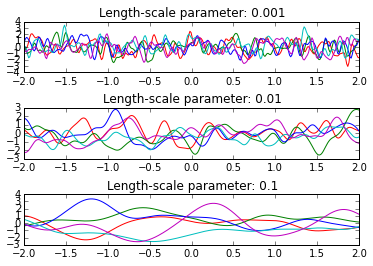

In [3]:
from scipy import spatial

pylab.subplots_adjust(hspace=0.7)
n_points = 300
n_curves = 5
l_values = [.001, .01, 0.1]

X_grid = np.linspace(-2,2,n_points)
X_grid = np.matrix(X_grid).T

color = 'rgbcm'

for i,l in enumerate(l_values):
    plt.subplot(len(l_values),1,i+1)
    
    #The GP allow us to obtain the Gaussian distribution of the
    #values of f for any particular selection of points x
    #We do so for the points in X_grid
    
    #We compute the distances among each pair of points in X_grid
    distances = spatial.distance.cdist(X_grid,X_grid,'euclidean')
    #And the covariance matrix
    K = np.exp(-np.power(distances,2)/(2*l))
    #For numerical reasons: we add a small constant along the main
    #diagonal to make sure K is positive-definite
    L = np.linalg.cholesky(K+1e-10*np.eye(n_points))
    
    #Next, we draw n_curves samples from the Gaussian distribution
    #with mean 0 and covariance matrix K
    for iter in range(n_curves):
        f_prime = np.random.randn(n_points,1)
        f = L.dot(f_prime)
        plt.plot(X_grid,f,color[iter%n_curves])

    plt.title('Length-scale parameter: '+str(l))

### 4.2.2 Modeling the posterior distribution of the targets

Let us assume that we wish to make predictions of the target variable at a collection of points $\{{{\bf x}^*}^{(1)}, {{\bf x}^*}^{(2)}, \dots, {{\bf x}^*}^{(P)}\}$. Let us put together the corresponding values of $f(\cdot)$ into a column vector ${\bf f}^*$. For the particular case in which we need to make predictions at a single point, such vector would become a scalar

#### Joint distribution of ${\bf f}$ and ${\bf f}^*$

Using the generative model: 

$$s^{(k)} = f({\bf x}^{(k)}) + \varepsilon^{(k)}$$

and assuming further that $f(\bf x)$ is a GP with mean 0 and covariance function $k({\bf x},{\bf x}')$, we can model the joint distribution of ${\bf f}$ and ${\bf f}^*$ as

$$\left[\begin{array}{c}{\bf f}\\{\bf f}^*\end{array}\right]~\sim~{\cal N}\left({\bf 0},\left[\begin{array}{cc}{\bf K} & {\bf K}_*^\top \\ {\bf K}_* & {\bf K}_{**} \end{array}\right]\right)$$

where:

   - ${\bf K}$ contains the covariance among the components of ${\bf f}$
   - ${\bf K}_{**}$ contains the covariance among the components of ${\bf f}^*$
   - ${\bf K}_{*}$ contains the covariance between components of ${\bf f}^*$ and ${\bf f}$
   

#### Joint distribution of ${\bf s}$ and ${\bf f}^*$

Since ${\bf s} = {\bf f} + {\pmb \varepsilon}$, and since the noise is independent of the values of ${\bf f}$, we have that 

$$\text{Cov}\{{\bf s}\} = \text{Cov}\{{\bf f}\} + \text{Cov}\{{\pmb \varepsilon}\} = {\bf K} + \sigma_\varepsilon^2 {\bf I}$$

Next, we can also see that

$$\text{Cov}\{{\bf f}^*,{\bf s}\} = \text{Cov}\{{\bf f}^*,({\bf f}+{\pmb \varepsilon})\} = \text{Cov}\{{\bf f}^*,{\bf f}\} = {\bf K}_*$$

Therefore, the joint distribution of ${\bf s}$ and ${\bf f}^*$ is 

$$\left[\begin{array}{c}{\bf s}\\{\bf f}^*\end{array}\right]~\sim~{\cal N}\left({\bf 0},\left[\begin{array}{cc}{\bf K} + \sigma_\varepsilon^2 {\bf I}& {\bf K}_*^\top \\ {\bf K}_* & {\bf K}_{**} \end{array}\right]\right)$$


#### Predictive distribution of ${\bf f}^*$ given ${\bf s}$

Using the results of Section 4.1.1, it is now straightforward to obtain the distribution of ${\bf f}^*$ given ${\bf s}$:

$${\bf f}^* | {\bf s}~\sim~{\cal N}\left({\bf K}_*[{\bf K+\sigma_\varepsilon^2 {\bf I}}]^{-1}{\bf s}, {\bf K}_{**} - {\bf K}_* [{\bf K+\sigma_\varepsilon^2 {\bf I}}]^{-1} {\bf K}_*^\top\right)$$

### 4.2.3 Gaussian Processes in practice

#### Predictive distribution computation

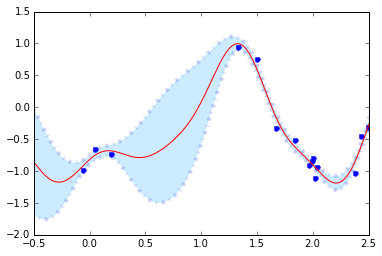

In [5]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2

#Generating the training points
X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
#These will be the points where the model will be evaluated
X_grid = np.linspace(-1,3,n_grid)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)
ax.set_xlim(-.5,2.5)

#GP hyperparameters
sigma_eps = 0.1
l = .1

#Covariance matrix computation
X_tr = np.matrix(X_tr)
X_grid = np.matrix(X_grid).T

dist = spatial.distance.cdist(X_tr,X_tr,'euclidean')
dist_ss = spatial.distance.cdist(X_grid,X_grid,'euclidean')
dist_s = spatial.distance.cdist(X_grid,X_tr,'euclidean')

K = np.exp(-np.power(dist,2)/(2*l))
K_ss = np.exp(-np.power(dist_ss,2)/(2*l))
K_s = np.exp(-np.power(dist_s,2)/(2*l))

#Posterior distribution of f_star
m = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(n_points))).dot(S_tr)
m = np.array(m).flatten()
Cov = K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(n_points))).dot(K_s.T)
#Variance of each prediction
v = np.diagonal(Cov)

plt.plot(X_grid,m,'r',label='Predictive mean')
plt.fill_between(np.array(X_grid).flatten(), m-np.sqrt(v), m+np.sqrt(v),
         alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
         linewidth=4, linestyle='dashdot', antialiased=True)
plt.show()

You can play modify the values of $\mbox{sigma_eps}$ and $\mbox{l}$, to see how the predictive distribution changes

## 4.3 Maximum likelihood selection of hyperparameters

As we did in the previous unit, we can find select the value of the hyperparameters to maximize the likelihood of the model. To this end, let us note that the pdf of ${\bf s}$ for given hyperparameters $\sigma_\varepsilon$ and $l$ is given by

$$p({\bf s}|\sigma_\varepsilon,l) = {\cal N}({\bf 0},{\bf K} + \sigma_\varepsilon^2 {\bf I}) = \frac{1}{(2 \pi)^{K/2}\mid{\bf K} + \sigma_\varepsilon^2 {\bf I}\mid^{1/2}} \exp\left(-\frac{1}{2}{\bf s}^\top ({\bf K} + \sigma_\varepsilon^2 {\bf I})^{-1} {\bf s}\right)$$

Instead of directly maximizing this expression, it is convenient to take the log, arriving at

$$\log p({\bf s}|\sigma_\varepsilon,l) = - \frac{K}{2}\log(2\pi) - \frac{1}{2} \log \mid{\bf K} + \sigma_\varepsilon^2 {\bf I}\mid -\frac{1}{2}{\bf s}^\top ({\bf K} + \sigma_\varepsilon^2 {\bf I})^{-1} {\bf s}$$

(be aware of the difference between $K$, the number of points in the training dataset, and ${\bf K}$, the covariance matrix of ${\bf f}$)

Selection of hyperparameters can be done with the objective of maximize this marginal likelihood, as illustrated next

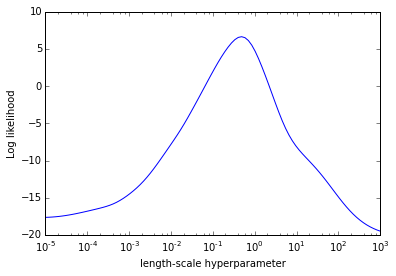

In [6]:
from math import pi

n_points = 15
frec = 3
std_n = 0.2

#Generating the training points
X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

#GP hyperparameters
sigma_eps = 0.3
l = np.logspace(-5,3,100)

#Covariance matrix computation
X_tr = np.matrix(X_tr)
X_grid = np.matrix(X_grid).T

dist = spatial.distance.cdist(X_tr,X_tr,'euclidean')

log_E = []

for l_iter in l:
    K = np.exp(-np.power(dist,2)/(2*l_iter))
    log_E_iter = -(n_points/2)*np.log(2*pi) \
        - np.log(np.linalg.det(K + sigma_eps**2 * np.eye(n_points))) \
        - 0.5 * S_tr.T.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(n_points))).dot(S_tr)
    log_E.append(log_E_iter[0,0])

plt.semilogx(l,log_E),
plt.xlabel('length-scale hyperparameter')
plt.ylabel('Log likelihood')

selected_l = l[np.argmax(log_E)]


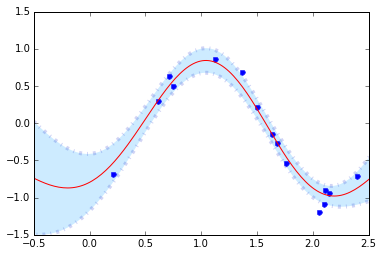

In [8]:
n_grid = 200

#These will be the points where the model will be evaluated
X_grid = np.linspace(-1,3,n_grid)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)
ax.set_xlim(-.5,2.5)

#GP hyperparameters
sigma_eps = 0.3
l = selected_l

#Covariance matrix computation
X_tr = np.matrix(X_tr)
X_grid = np.matrix(X_grid).T

dist = spatial.distance.cdist(X_tr,X_tr,'euclidean')
dist_ss = spatial.distance.cdist(X_grid,X_grid,'euclidean')
dist_s = spatial.distance.cdist(X_grid,X_tr,'euclidean')

K = np.exp(-np.power(dist,2)/(2*l))
K_ss = np.exp(-np.power(dist_ss,2)/(2*l))
K_s = np.exp(-np.power(dist_s,2)/(2*l))

#Posterior distribution of f_star
m = K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(n_points))).dot(S_tr)
m = np.array(m).flatten()
Cov = K_ss - K_s.dot(np.linalg.inv(K + sigma_eps**2 * np.eye(n_points))).dot(K_s.T)
#Variance of each prediction
v = np.diagonal(Cov)

plt.plot(X_grid,m,'r',label='Predictive mean')
plt.fill_between(np.array(X_grid).flatten(), m-np.sqrt(v), m+np.sqrt(v),
         alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
         linewidth=4, linestyle='dashdot', antialiased=True)
plt.show()